The project I have identified for Capstone relates to UN voting records.  I'm interested in how countries can be grouped into voting blocks based on their voting record corresponding to resolutions raised in the General Assembly (not to be confused with General Assembly the education institution).  Once a grouping structure is defined based on voting using clustering I seek to understand what factors lead to these groupings.

Potential variables I've considered include: gross bilateral trade, government type, language(s) spoken, religoin(s), military allience/cooperation.

Additionally I would like to be able to use the information derived to build a time-series analysis to describe how these groupings and relationships have changed over time (1948 - 2017).

I've identified several useful data sources but there are certainly issues. 

My most important data set is the voting records of each country for each resolution.  I have this data, but as you will see from the data below, I'm not able to read everything in, both because I have issues importing one of the .tab files and because several of the files are in 'R' 

Risks:
- Not being able to extract from R
- Not being able to properly merge data files
- Not able to find acquire and merge additional variable data such as bilateral trade
- Model does not work


# Initial EDA on Raw UNGA dataset

Data set is taken from here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379

In [400]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import scale

%matplotlib inline

In [401]:
df_votes = pd.read_csv('~/Desktop/dataverse_files/UNVotes1-72.tab',sep='\t')
# This is a long list of vote tallies by resolution

In [402]:
df_votes.head(3)
# This is what the dataset looks like. {rcid: resolution ID, ccode: Country Code, 
# session: Count of Assemblies from 1946, member: Country member code, vote: desicion on resolution
# .....rest is obvious}

# vote – Vote choice
# 1 – Yes
# 2 – Abstain
# 3 – No
# 8 – Absent
# 9 – Not a member

,rcid,ccode,session,member,vote,Country,Countryname,year
0,3.0,2,1.0,1.0,1,USA,United States of America,1946
1,3.0,20,1.0,1.0,3,CAN,Canada,1946
2,3.0,31,1.0,NaN,9,BHS,Bahamas,1946


In [403]:
df_votes.shape
# 1,099,156  > 1M rows.

(1099156, 8)

In [404]:
df_votes.dtypes 
# All seem to be in useable format. 

rcid           float64
ccode            int64
session        float64
member         float64
vote             int64
Country         object
Countryname     object
year             int64
dtype: object

In [405]:
df_votes.info()
# Indicates there are a huge number
print("Number of missing values in 'member':" +str(1098964-846858))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099156 entries, 0 to 1099155
Data columns (total 8 columns):
rcid           1099156 non-null float64
ccode          1099156 non-null int64
session        1098964 non-null float64
member         846858 non-null float64
vote           1099156 non-null int64
Country        1091797 non-null object
Countryname    1098987 non-null object
year           1099156 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 67.1+ MB
Number of missing values in 'member':252106


In [406]:
df_votes.describe(include=['object'])
# This suggests to me countries may have been renamed and kept the same country code.
# Requires further inquiry

,Country,Countryname
count,1091797,1098987
unique,198,200
top,SLV,France
freq,5598,5598


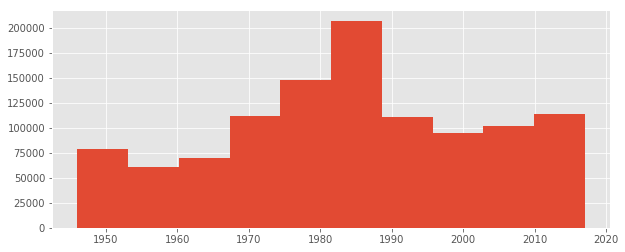

In [407]:
df_votes.year.hist(figsize=(10,4));
# looks like voting peaked in the 60's, meaning unclear

        vote               Countryname   rcid  member
129626     1  United States of America  627.0     1.0
129627     1                    Canada  627.0     1.0
129628     9                   Bahamas  627.0     NaN
129629     3                      Cuba  627.0     1.0
129630     8                     Haiti  627.0     1.0
129631     2        Dominican Republic  627.0     1.0
129632     9                   Jamaica  627.0     NaN
129633     9       Trinidad and Tobago  627.0     NaN
129634     9                  Barbados  627.0     NaN
129635     9                  Dominica  627.0     NaN


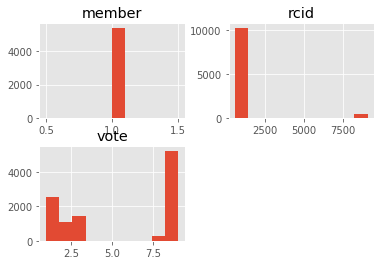

In [408]:
df_votes[df_votes.year == 1960][['vote','Countryname','rcid', 'member']].hist()
# This appears to show that: 1. There are more non-member votes than member votes in 1960
# resolution 'present' most likely.  There are a low number 8's for 'absent'.  These should
# be dropped, as an absense is usually due to a structural problem such as a civil war or 
# financial crisis.  
# 3's show there are a large number of abstaining votes.  Literature shows this is generally 
# a negative refletion on that countries view of the resulution, although negative wighting is
# somewhat arbitrary

print(df_votes[df_votes.year == 1960][['vote','Countryname','rcid', 'member']].head(10))
# it appears that countries are labeled as 'Nan' before the country joined the UN.  
# I can convert these values to represent a binary, 1 = member, 0 = non_member

# Data Cleaning and Munging

In [409]:
# I'm going to replace the 'Nan' values in 'member' with 0just to clean this up a bit and 
# hopefuly use the value for future analysis
df_votes.member = df_votes.member.fillna(value=0)

In [410]:
df_votes[df_votes.year == 1960][['vote','Countryname','rcid', 'member']].head(5)

,vote,Countryname,rcid,member
129626,1,United States of America,627.0,1.0
129627,1,Canada,627.0,1.0
129628,9,Bahamas,627.0,0.0
129629,3,Cuba,627.0,1.0
129630,8,Haiti,627.0,1.0


In [411]:
df_votes[(df_votes.year == 1960) & (df_votes.vote == 1)].groupby('Countryname').sum().head()
#df_votes[(df_votes.year == 1960) & (df_votes.Countryname == "Australia")]
#users[(users.age < 20) & (users.gender=='M')]

,rcid,ccode,session,member,vote,year
Countryname,,,,,,
Afghanistan,41021.0,25900,555.0,37.0,37,72520
Albania,30688.0,11526,510.0,34.0,34,66640
Argentina,34416.0,4320,405.0,27.0,27,52920
Australia,28423.0,16200,270.0,18.0,18,35280
Austria,31911.0,7015,345.0,23.0,23,45080


# Further EDA and Munging for First Clustering Attempt

In [412]:
df_votes.head(2)
# To add to the model I need to drop the objects from my dataframe (Countr and Countryname)
# I can use the country code to merge the names back onto the dataframe

,rcid,ccode,session,member,vote,Country,Countryname,year
0,3.0,2,1.0,1.0,1,USA,United States of America,1946
1,3.0,20,1.0,1.0,3,CAN,Canada,1946


In [413]:
df_votes_C = df_votes.drop(['Country', 'Countryname'], axis=1)

In [414]:
df_votes_C.head(2)
# Updted df w/out objects

,rcid,ccode,session,member,vote,year
0,3.0,2,1.0,1.0,1,1946
1,3.0,20,1.0,1.0,3,1946


In [415]:
df_votes_C.info()
# looks like there are still some 'nulls' in session series.  Will ignore for now 
# because I expect to filter on year at the moment

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099156 entries, 0 to 1099155
Data columns (total 6 columns):
rcid       1099156 non-null float64
ccode      1099156 non-null int64
session    1098964 non-null float64
member     1099156 non-null float64
vote       1099156 non-null int64
year       1099156 non-null int64
dtypes: float64(3), int64(3)
memory usage: 50.3 MB


In [416]:
# I want to cluster resolution votes on 1s and 0s alone to start.  How will I eliminate adding
# records that have a different vote score?  I'll start by creating two DFs for the year 1960
# just to see how many times a country will vote under the diff 'vote categories

In [417]:
# creating a df for 1960 alone
df_votes_1960 = df_votes_C[df_votes.year == 1960]

In [418]:
# Now I want to group by vote type. Just to see
df_votes_1960.vote.value_counts().sort_index()
#It looks like '9' for non-members is the domminant cat.  

1    2577
2    1084
3    1461
8     276
9    5240
Name: vote, dtype: int64

In [419]:
# Now I want to see which countries aren't members
# Appears to show that about 98 nations represented in the data set were not members
# at the time of voting.  Given the list of countries this make intuitive sense given
# that most are obviously not yet countries in 1960 or are developing nations, which
# in 1960 were not well represented in the UN General Assembly

df_votes[(df_votes.year == 1960) & (df_votes.vote == 9)].groupby('Countryname').sum().head()

,rcid,ccode,session,member,vote,year
Countryname,,,,,,
Algeria,52011.0,33210,810.0,0.0,486,105840
Andorra,52011.0,12528,810.0,0.0,486,105840
Angola,52011.0,29160,810.0,0.0,486,105840
Antigua and Barbuda,52011.0,3132,810.0,0.0,486,105840
Armenia,52011.0,20034,810.0,0.0,486,105840


In [420]:
# After confirming the meaning of non-member 'votes' I'm going to drop all of the countries
# in 1960 that were not members from the df_votes_1960 dataframe. I believe I can drop all 
# non-member records from the entire df, but I will wait for the moment:

df_votes_1960_members = df_votes_1960[df_votes_1960.member == 1]

In [421]:
df_votes_1960_members.vote.value_counts().sort_index()
# I wonder where the 2 "9" value "non-member" votes are coming from.  Next cell

1    2577
2    1084
3    1461
8     276
9       2
Name: vote, dtype: int64

In [422]:
df_votes_1960_members[df_votes_1960_members.vote == 9]
# Nigeria is the only country that has a non-member vote as a member
# This is a coding error.  They became a member, but at the time of voting
# They were not yet a member.  This goes to the pt that dropping recodes based 
# on recorded membership my create minor errors in this data set.  'Vote' is a more 
# precise measure for indicating whether a country is a member at the time of the resolution

,rcid,ccode,session,member,vote,year
149821,9040.0,475,15.0,1.0,9,1960
150018,9041.0,475,15.0,1.0,9,1960


In [423]:
# I'm going to create a new DF for testing where I only look at 1960 w/only votes 
# for 'yes' and 'no'
df_votes_1960_binary = df_votes_1960[(df_votes_1960.vote <= 1) | (df_votes_1960.vote == 3)]
df_votes_1960_binary.vote.value_counts()
# My data set now shows only yes and no votes in 1960

1    2577
3    1461
Name: vote, dtype: int64

In [424]:
df_votes_1960_binary.head()

,rcid,ccode,session,member,vote,year
129626,627.0,2,15.0,1.0,1,1960
129627,627.0,20,15.0,1.0,1,1960
129629,627.0,40,15.0,1.0,3,1960
129644,627.0,91,15.0,1.0,3,1960
129647,627.0,94,15.0,1.0,3,1960


In [425]:
# I want to turn my 1 = yes and 3 = no into 0 = no and 1 = yes

#df_votes_1960_binary
df_votes_1960_binary.vote = df_votes_1960_binary.vote.replace(to_replace=3, value=0, inplace=False, limit=None, regex=False, method='pad', axis=None)
df_votes_1960_binary.head(2)

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,rcid,ccode,session,member,vote,year
129626,627.0,2,15.0,1.0,1,1960
129627,627.0,20,15.0,1.0,1,1960


In [426]:
features = ['']

In [427]:
df_votes_1960_binary.sort_values('ccode').head()

,rcid,ccode,session,member,vote,year
129626,627.0,2,15.0,1.0,1,1960
134551,652.0,2,15.0,1.0,0,1960
134748,653.0,2,15.0,1.0,1,1960
130217,630.0,2,15.0,1.0,1,1960
134945,654.0,2,15.0,1.0,0,1960


In [428]:
# After doing this model with my current dataframe, I realize this makes no sense.  I have
# a new row for each resolution/country combo.  Instead make the country the record, 
# Then I can plot the country, and the binary on their vote for each resolution is the feature
# I can start by dropping unused columns (keeping ccode)

In [429]:
df_1960_features = df_votes_1960_binary.drop([ 'session', 'year'], axis=1)

In [430]:
df_1960_features.head()

,rcid,ccode,member,vote
129626,627.0,2,1.0,1
129627,627.0,20,1.0,1
129629,627.0,40,1.0,0
129644,627.0,91,1.0,0
129647,627.0,94,1.0,0


In [431]:
df_1960_features['v_res'] = df_1960_features['rcid']*df_1960_features['vote']
df_1960_features.head()

,rcid,ccode,member,vote,v_res
129626,627.0,2,1.0,1,627.0
129627,627.0,20,1.0,1,627.0
129629,627.0,40,1.0,0,0.0
129644,627.0,91,1.0,0,0.0
129647,627.0,94,1.0,0,0.0


In [432]:
# Create a dummy variable for each yes-vote/resolution combination
# and concatinate with the previous df_1960_dummies dataframe
# Now need to drop the res_0.0 column and group_by.sum() the df
df_1960_dummies = pd.concat([df_1960_features,pd.get_dummies(df_1960_features.v_res, prefix='res_')], axis = 1)
df_1960_dummies.head()

,rcid,ccode,member,vote,v_res,res__0.0,res__627.0,res__628.0,res__629.0,res__630.0,...,res__671.0,res__672.0,res__673.0,res__674.0,res__675.0,res__676.0,res__677.0,res__678.0,res__9040.0,res__9041.0
129626,627.0,2,1.0,1,627.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129627,627.0,20,1.0,1,627.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129629,627.0,40,1.0,0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129644,627.0,91,1.0,0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129647,627.0,94,1.0,0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [433]:
# need to drop res_0.0 column

In [434]:
df_t = df_1960_dummies.groupby('ccode').sum()
df_t.shape
# there were 54 resolutions in 1960
# I'm going to have to do something to make each resultion its own column
# That column will need to look at the vote for the country in the row and assign a binary

(99, 59)

In [435]:
df_t.head()

,rcid,member,vote,v_res,res__0.0,res__627.0,res__628.0,res__629.0,res__630.0,res__631.0,...,res__671.0,res__672.0,res__673.0,res__674.0,res__675.0,res__676.0,res__677.0,res__678.0,res__9040.0,res__9041.0
ccode,,,,,,,,,,,,,,,,,,,,,
2,45332.0,44.0,21,30373.0,23,1,1,0,1,0,...,0,1,0,0,0,0,0,1,1,1
20,45461.0,44.0,27,34397.0,17,1,1,0,1,0,...,0,1,1,1,1,0,0,1,1,1
40,50058.0,51.0,37,41018.0,14,0,0,1,0,1,...,1,0,1,1,1,1,1,0,1,1
41,42150.0,39.0,25,33118.0,14,0,1,0,1,0,...,0,1,0,1,1,1,0,0,1,1
42,31679.0,23.0,16,27172.0,7,0,1,0,1,0,...,0,0,0,1,1,0,0,0,1,1


In [436]:
df_t = df_t.drop(['v_res', 'res__0.0', 'vote','member','rcid'], axis=1)

In [437]:
print(list(df_t))

['res__627.0', 'res__628.0', 'res__629.0', 'res__630.0', 'res__631.0', 'res__632.0', 'res__633.0', 'res__634.0', 'res__635.0', 'res__636.0', 'res__637.0', 'res__638.0', 'res__639.0', 'res__640.0', 'res__641.0', 'res__642.0', 'res__643.0', 'res__644.0', 'res__645.0', 'res__646.0', 'res__647.0', 'res__648.0', 'res__649.0', 'res__650.0', 'res__651.0', 'res__652.0', 'res__653.0', 'res__654.0', 'res__655.0', 'res__656.0', 'res__657.0', 'res__658.0', 'res__659.0', 'res__660.0', 'res__661.0', 'res__662.0', 'res__663.0', 'res__664.0', 'res__665.0', 'res__666.0', 'res__667.0', 'res__668.0', 'res__669.0', 'res__670.0', 'res__671.0', 'res__672.0', 'res__673.0', 'res__674.0', 'res__675.0', 'res__676.0', 'res__677.0', 'res__678.0', 'res__9040.0', 'res__9041.0']


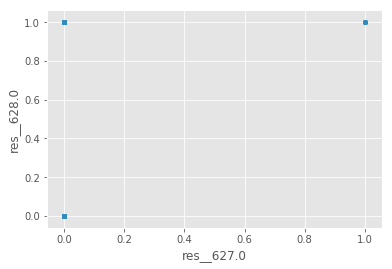

In [438]:
features = list(df_t)
features
df_t[features].plot(kind="scatter", x=features[0], y=features[1])

In [439]:
df_t[features].head()

,res__627.0,res__628.0,res__629.0,res__630.0,res__631.0,res__632.0,res__633.0,res__634.0,res__635.0,res__636.0,...,res__671.0,res__672.0,res__673.0,res__674.0,res__675.0,res__676.0,res__677.0,res__678.0,res__9040.0,res__9041.0
ccode,,,,,,,,,,,,,,,,,,,,,
2,1,1,0,1,0,0,0,1,1,1,...,0,1,0,0,0,0,0,1,1,1
20,1,1,0,1,0,0,0,1,1,1,...,0,1,1,1,1,0,0,1,1,1
40,0,0,1,0,1,1,1,0,0,0,...,1,0,1,1,1,1,1,0,1,1
41,0,1,0,1,0,0,0,1,1,1,...,0,1,0,1,1,1,0,0,1,1
42,0,1,0,1,0,0,0,1,1,1,...,0,0,0,1,1,0,0,0,1,1


Silhouette Score:  0.347302562372


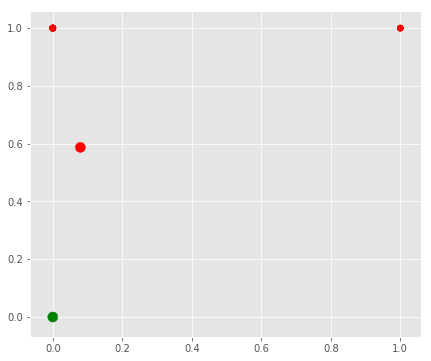

In [440]:
# Run k-means against our features with three clusters.
k = 2
model = KMeans(n_clusters=k, max_iter=1)
model.fit(df_t[features].values)

# Check our results.
# Assign clusters back to our DataFrame.
df_t['cluster'] = model.labels_

# Get our centroids.
centroids    =  model.cluster_centers_
cc           =  pd.DataFrame(centroids)

# Set up some colors for plotting (for later).
colors = {'D':'red', 'E':'blue', 'F':'green', 'H': 'yellow'}
base_colors  =  ['r', 'g', 'b', 'y']
colors       =  [base_colors[centroid] for centroid in model.labels_]

# Update x and y of our final clusters to plot later.
fig, ax      =  plt.subplots(figsize=(7,6))

# Plot the scatter of our points with calculated centroids.
ax.scatter(df_t[features[0]], df_t[features[1]], c=colors)
ax.scatter(cc[0], cc[1], c=base_colors, s=100) # cc.index

# And our score is:
print ("Silhouette Score: ", silhouette_score(df_t[features], df_t['cluster'], metric='euclidean'))

In [471]:
df_votes.head()

,rcid,ccode,session,member,vote,Country,Countryname,year
0,3.0,2,1.0,1.0,1,USA,United States of America,1946
1,3.0,20,1.0,1.0,3,CAN,Canada,1946
2,3.0,31,1.0,0.0,9,BHS,Bahamas,1946
3,3.0,40,1.0,1.0,1,CUB,Cuba,1946
4,3.0,41,1.0,1.0,1,HTI,Haiti,1946


In [445]:
df_t.reset_index(inplace=True)
df_t.head()

,ccode,res__627.0,res__628.0,res__629.0,res__630.0,res__631.0,res__632.0,res__633.0,res__634.0,res__635.0,...,res__672.0,res__673.0,res__674.0,res__675.0,res__676.0,res__677.0,res__678.0,res__9040.0,res__9041.0,cluster
0,2,1,1,0,1,0,0,0,1,1,...,1,0,0,0,0,0,1,1,1,0
1,20,1,1,0,1,0,0,0,1,1,...,1,1,1,1,0,0,1,1,1,0
2,40,0,0,1,0,1,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
3,41,0,1,0,1,0,0,0,1,1,...,1,0,1,1,1,0,0,1,1,0
4,42,0,1,0,1,0,0,0,1,1,...,0,0,1,1,0,0,0,1,1,0


In [473]:
df_votes[['ccode','Countryname']].head()

,ccode,Countryname
0,2,United States of America
1,20,Canada
2,31,Bahamas
3,40,Cuba
4,41,Haiti


In [482]:
df_name_index = pd.DataFrame(df_votes.groupby(['ccode', 'Countryname'])['Countryname'].count())

In [501]:
df_name_index['count'] = df_name_index.Countryname
df_name_index = df_name_index.drop([ 'Countryname'], axis=1)
df_name_index.head()

,,count
ccode,Countryname,
2,United States of America,5598
20,Canada,5598
31,Bahamas,5598
40,Cuba,5598
41,Haiti,5598


In [509]:
df_name_index.reset_index(inplace=True)
#df_name_index.tail(100)

,ccode,Countryname,count
100,452,Ghana,5598
101,461,Togo,5598
102,471,Cameroon,5598
103,475,Nigeria,5598
104,481,Gabon,5598
105,482,Central African Republic,5598
106,483,Chad,5598
107,484,Congo,5598
108,490,Democratic Republic of the Congo,5598
109,500,Uganda,5598


In [515]:
#df_t.join(df_name_index, how='left', on='ccode')
df_votes_1960 = pd.merge(df_t, df_name_index, on='ccode')
df_votes_1960.head()

,ccode,res__627.0,res__628.0,res__629.0,res__630.0,res__631.0,res__632.0,res__633.0,res__634.0,res__635.0,...,res__674.0,res__675.0,res__676.0,res__677.0,res__678.0,res__9040.0,res__9041.0,cluster,Countryname,count
0,2,1,1,0,1,0,0,0,1,1,...,0,0,0,0,1,1,1,0,United States of America,5598
1,20,1,1,0,1,0,0,0,1,1,...,1,1,0,0,1,1,1,0,Canada,5598
2,40,0,0,1,0,1,1,1,0,0,...,1,1,1,1,0,1,1,1,Cuba,5598
3,41,0,1,0,1,0,0,0,1,1,...,1,1,1,0,0,1,1,0,Haiti,5598
4,42,0,1,0,1,0,0,0,1,1,...,1,1,0,0,0,1,1,0,Dominican Republic,5598


In [510]:
df_votes.to_csv('df_votes.csv', index=False)

In [511]:
df_t.to_csv('df_t.csv', index=False)

In [ ]:
#let's see which countres are in the two clusters

In [531]:
df_votes_1960[df_votes_1960.cluster == 1]['Countryname'] 

2                    Cuba
30                 Poland
32                Hungary
33         Czechoslovakia
35                Albania
36             Yugoslavia
39               Bulgaria
40                Romania
41     Russian Federation
42                Ukraine
43                Belarus
44                Finland
49                   Mali
54                 Guinea
57                  Ghana
58                   Togo
60                Nigeria
66                Somalia
67               Ethiopia
70                Morocco
71                Tunisia
72                  Libya
73                  Sudan
76                   Iraq
77                  Egypt
78                Lebanon
81           Saudi Arabia
82    Yemen Arab Republic
83            Afghanistan
86                  India
88                Myanmar
89              Sri Lanka
90                  Nepal
92               Cambodia
94               Malaysia
96              Indonesia
Name: Countryname, dtype: object

In [532]:
 df_votes_1960.to_csv('df_votes_1960.csv', index=False)

'tsne' can be used in an attempt to visualize high dimensional data.  Should be a packeage that can take cluster labels and data an position on a plane to visualize closeness

# Junk and other imports

In [45]:
# users[users.age == 20]
#
# Select one column from the filtered results.
# users[users.age < 20].occupation
# users[users.age < 20].occupation.value_counts()
# users[(users.age < 20) & (users.gender=='M')]
# users[users.occupation.isin(['doctor', 'lawyer'])]

In [ ]:
df_points = pd.read_csv('~/Desktop/dataverse_files/IdealpointsPublished.tab',sep='\t')
# df points is Ideal point data. Unit of analysis is the country-session 
# (which corresponds closely but not perfectly, to country-year). This 
# contains country-specific ideal point estimates. 

In [ ]:
df_points.columns

In [ ]:
df_dyadic = pd.read_csv('~/Desktop/dataverse_files/Dyadicdata.tab',sep='\t')

In [ ]:
df_dyadic.columns
# Dyadid affinity and ideal point data. Unit of analysis is the dyad-session (year). 
# This file contains distances between country ideal points as well as Affinity scores 
# (although we recommend against using these). 

In [ ]:
df_descriptions = pd.read_csv('~/documents/UN-Capstone/Dscription.csv')

In [ ]:
df_descriptions.tail(30)

In [ ]:
df_descriptions.head()

In [ ]:
df_UNAid = pd.read_csv('~/documents/UN-Capstone/net_aid.csv')

In [ ]:
df_UNAid